## Comunità

Il rilevamento delle comunità di rete consiste nel trovare una partizione che realizzi una buona separazione tra i gruppi di nodi. Prima di capire come trovare buone partizioni di un grafo, abbiamo bisogno di un obiettivo, cioè di un modo per misurare la bontà della partizione. 
La modularità è una di queste funzioni obiettivo.

### Modularità
La modularità in network science è una misura della struttura modulare di una rete, ovvero la suddivisione della rete in gruppi di nodi (moduli o comunità) che sono più densamente interconnessi tra loro rispetto ad altri nodi all'interno della rete. In altre parole, la modularità quantifica la presenza di sottoreti o cluster di nodi altamente interconnessi all'interno della rete.

Una comunità può essere definita come un gruppo di nodi altamente connessi tra loro e meno connessi con i nodi esterni alla comunità.

In [3]:
%matplotlib inline
import networkx as nx
import gzip
import matplotlib.pyplot as plt
import random
G = nx.read_graphml('openflights_world.graphml.gz')

Provo a fare un campionamento random e a valutarne la modularità

sample() è una funzione integrata nel modulo random di Python che restituisce un elenco di elementi di lunghezza particolare, scelti dalla sequenza 

C:\Users\ricca\AppData\Local\Temp\ipykernel_11984\3149432963.py:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_nodes = random.sample(G.nodes, 100)


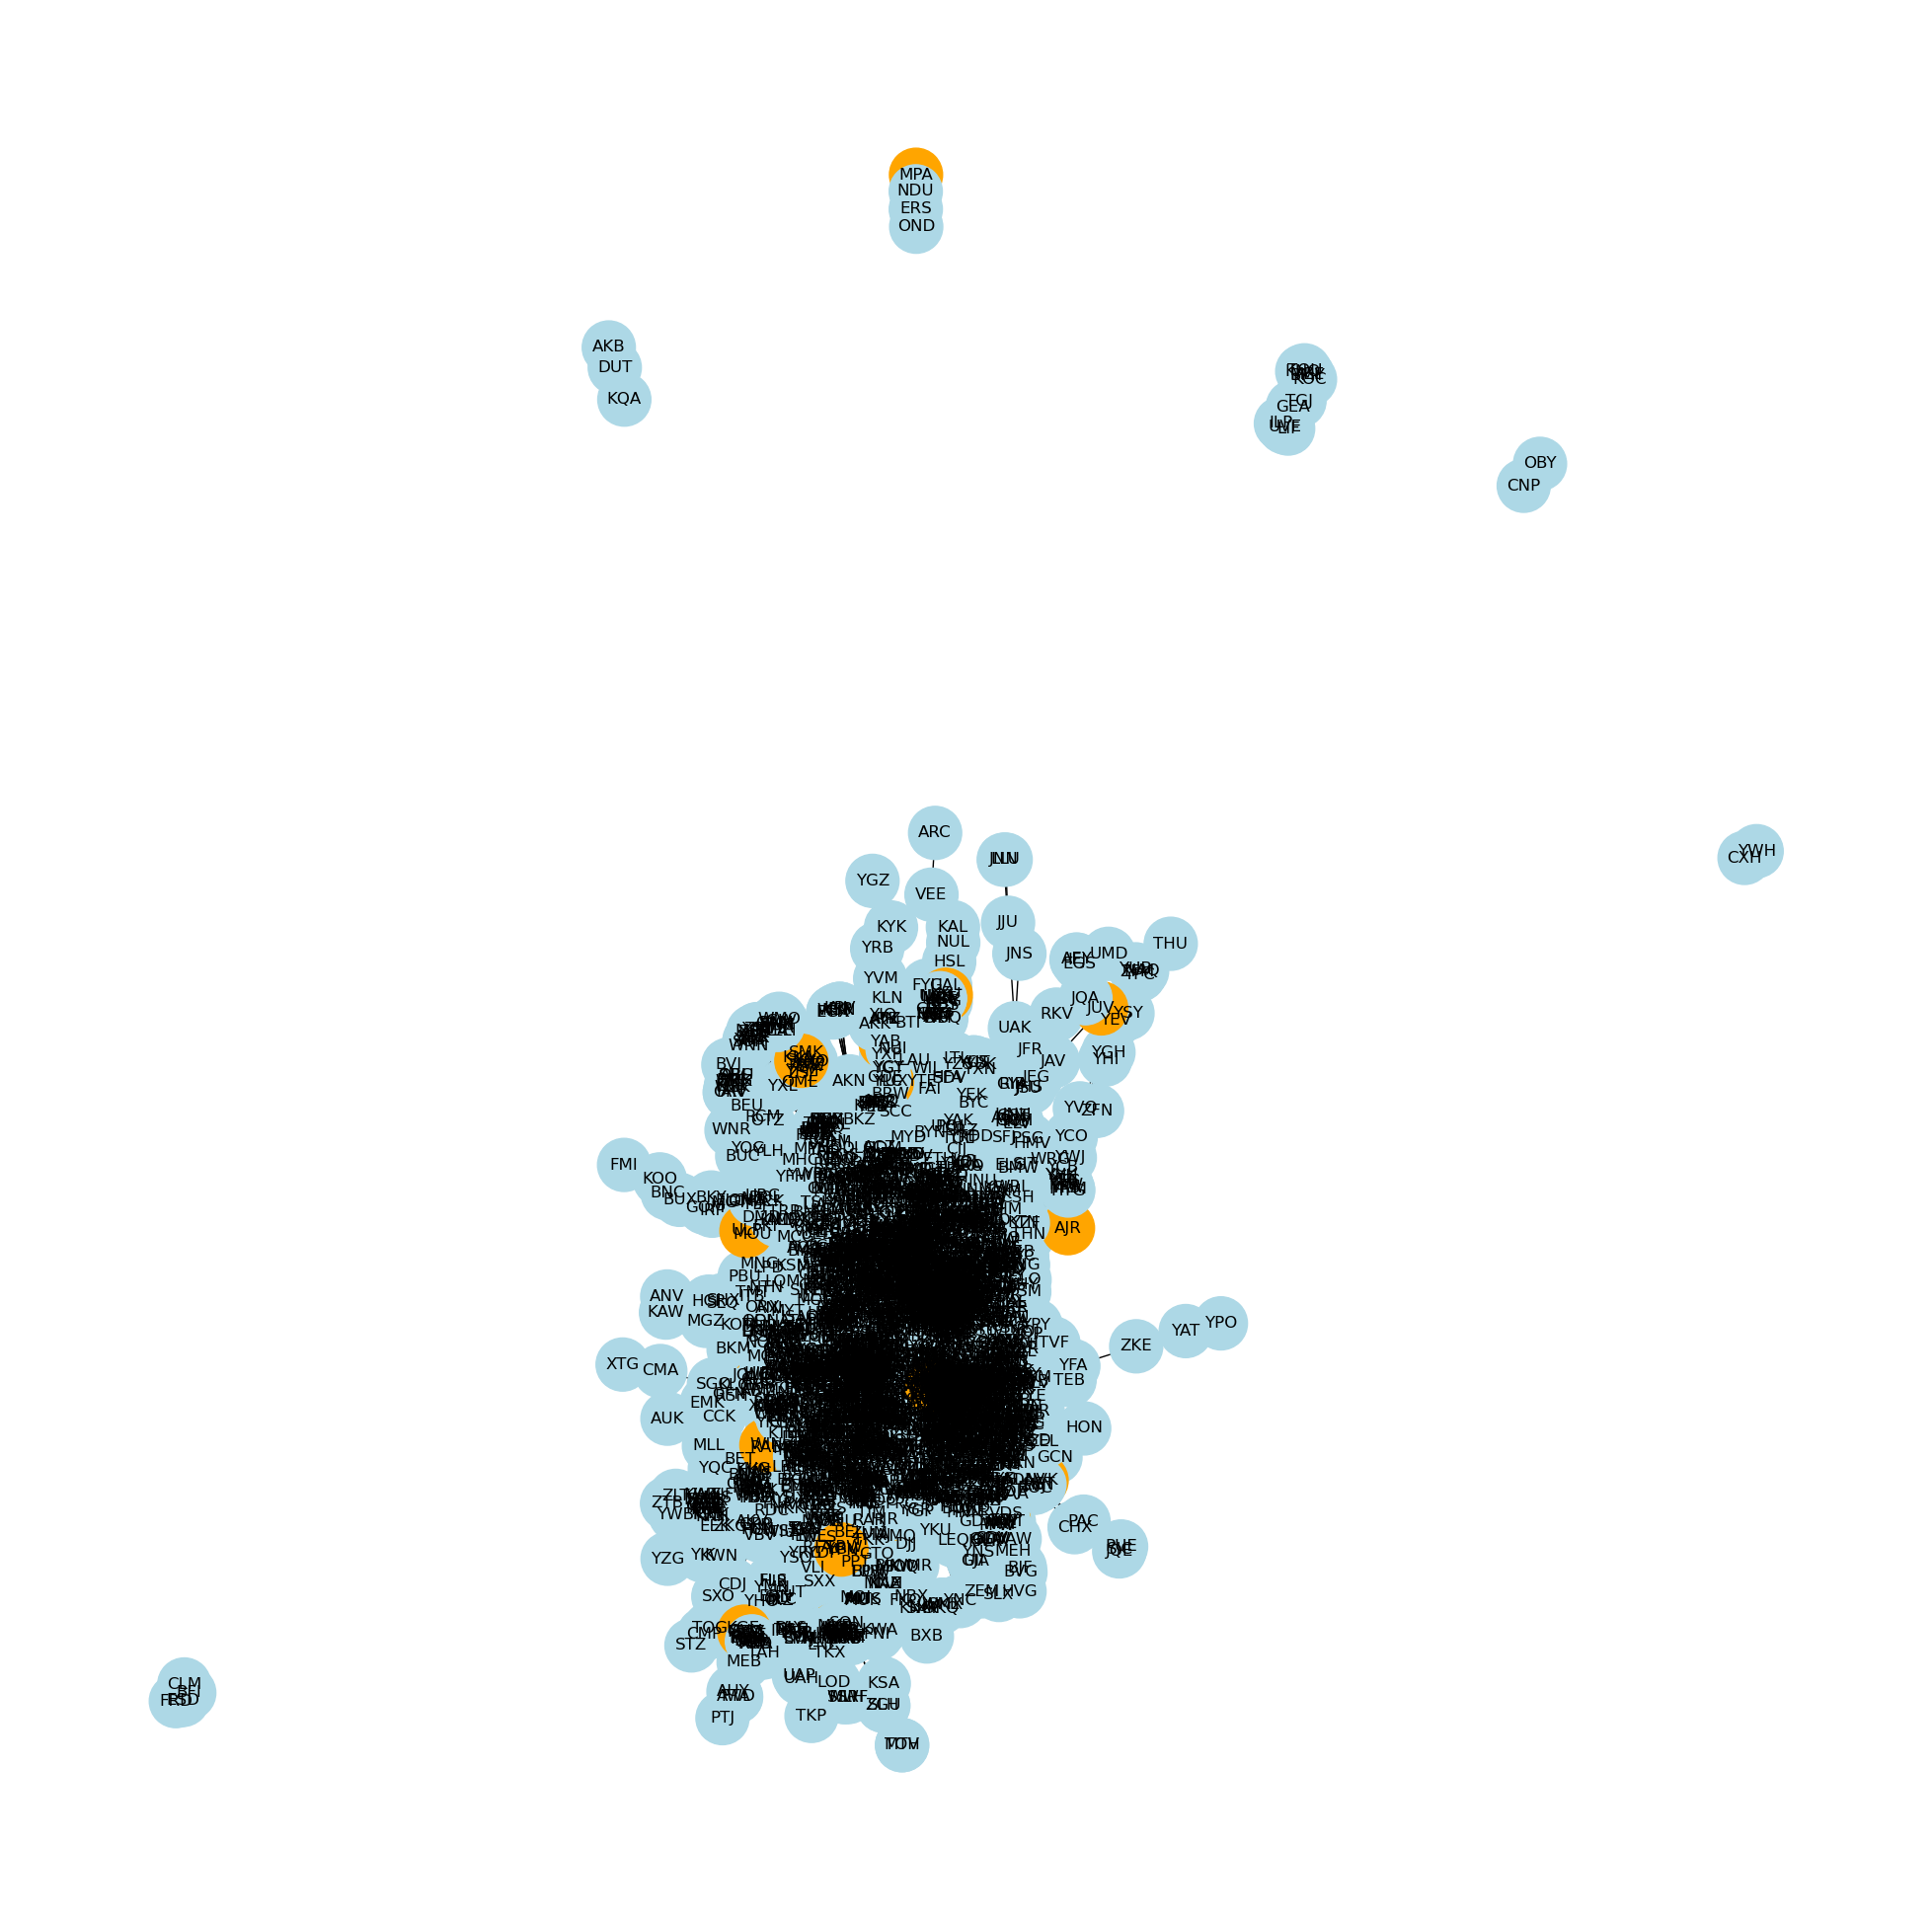

In [10]:
random_nodes = random.sample(G.nodes, 100)
random_partition = [set(random_nodes),
                    set(G.nodes) - set(random_nodes)]
random_node_colors = ['orange' if n in random_nodes else 'lightblue' for n in G.nodes]
fig, ax = plt.subplots(figsize=(25, 25))
nx.draw(G, node_color=random_node_colors, node_size=1500 , with_labels=True)

In [11]:
nx.community.quality.modularity(G, random_partition)

-0.0001454041057397031

### Clustering tramite Girvan-Newman

L'algoritmo di clustering di Girvan-Newman è un algoritmo di clustering gerarchico bottom-up che si basa sulla rimozione iterativa degli archi del grafo.

L'idea alla base dell'algoritmo è che gli archi che collegano le comunità hanno una centralità più elevata rispetto agli archi interni alle comunità. L'algoritmo si basa sulla rimozione graduale degli archi meno importanti della rete. Utilizza la metrica di "betweenness" degli archi, che indica quanti cammini più brevi attraversano ciascun arco della rete. Gli archi con la metrica di betweenness più elevata vengono rimossi gradualmente, finché la rete non si frammenta in diverse comunità.

Più precisamente, l'algoritmo funziona nel seguente modo:

- Calcola la metrica di betweenness per tutti gli archi della rete
- Rimuove l'arco con la metrica di betweenness più alta
- Calcola la metrica di betweenness per tutti gli archi della rete rimanente
- Ripeti i passaggi 2 e 3 fino a quando tutti gli archi sono stati rimossi o la rete si è frammentata in un numero sufficiente di comunità

In pratica, l'algoritmo di Girvan-Newman funziona come una serie di tagli successivi del grafo, che rimuovono gli archi meno importanti e creano sempre più componenti connesse. L'algoritmo è molto efficace nel rilevare comunità anche quando queste non sono evidenti a prima vista, ma può essere computazionalmente costoso per grafi molto grandi

In [1]:
%matplotlib inline
import networkx as nx
import gzip
import matplotlib.pyplot as plt
import random
G = nx.read_graphml('openflights_world.graphml.gz')

Questa sarebbela procedura, ma visto che ci mette tantissimo a terminare ho provato ad usare la funzione fornita da NetworkX



In [ ]:
'''
G_copy = G.copy()
partition_sequence = []
for _ in range(G_copy.number_of_edges()):
    my_edge_betweenness = nx.edge_betweenness_centrality(G_copy) #ottengo la betweenness di ogni singolo arco
    most_valuable_edge = max(G_copy.edges(), key=my_edge_betweenness.get) # ricavo l'arco con betweenness massima
    G_copy.remove_edge(*most_valuable_edge) #rimuovo quell'arco
    my_partition = list(nx.connected_components(G_copy)) #creo la partizione usando le componenti connesse
    partition_sequence.append(my_partition)
'''

In [21]:
def modularity(G, partition):
    W = sum(G.edges[v, w].get('weight', 1) for v, w in G.edges)
    summation = 0
    for cluster_nodes in partition:
        s_c = sum(G.degree(n, weight='weight') for n in cluster_nodes)
        # Use subgraph to count only internal links
        C = G.subgraph(cluster_nodes)
        W_c = sum(C.edges[v, w].get('weight', 1) for v, w in C.edges)
        summation += W_c - s_c ** 2 / (4 * W)
    
    return summation / W

In [ ]:
partition_sequence = nx.community.girvan_newman(G) # ricavo le possibili partizioni
# valuto la modularità delle partizioni
modularity_sequence = [modularity(G, p) for p in partition_sequence]


Questa sequenza appena calcolata rappresenta quindi la modularità della partizione a ogni passo dell'algoritmo

In [ ]:
import matplotlib.pyplot as plt
plt.plot(modularity_sequence)
plt.ylabel('Modularity')
plt.xlabel('Algorithm step')

Ricavo la partizione con modularità massima

In [ ]:
G_copy = G.copy()
partition_sequence = nx.community.girvan_newman(G) # ricavo le possibili partizioni
def my_modularity(partition):
    return nx.community.quality.modularity(G_copy, partition)
best_partition = max(partition_sequence, key=my_modularity)

In [ ]:
def create_partition_map(partition):
    partition_map = {}
    for idx, cluster_nodes in enumerate(partition):
        for node in cluster_nodes:
            partition_map[node] = idx
    return partition_map

In [ ]:
best_partition_map = create_partition_map(best_partition)

node_colors = [best_partition_map[n] for n in G.nodes()]
fig, ax = plt.subplots(figsize=(25, 25))
nx.draw_networkx(G_copy, node_size=1000 , with_labels=True, node_color=node_colors)

In [ ]:
nx.community.quality.modularity(G_copy, best_partition)